# Import modules

In [3]:
import tensorflow as tf
import os
import cv2
import numpy as np
from tensorflow.keras import backend, optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GaussianNoise, Dense
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
%matplotlib inline

from vit_keras import vit

# Prepare generators

In [ ]:
train_path = './dataset/20train'
test_path = './dataset/20test'
valid_path = './dataset/20valid'

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1,
)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='sparse',
    shuffle=False,
)

validation_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='sparse',
    shuffle=False,
  )

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='sparse',
    shuffle=False
    )


def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Load pre-trained ViT Model

In [ ]:
backend.clear_session()

vit_model = vit.vit_l32(
    image_size=224,
    pretrained=True,
    include_top=False,
    pretrained_top=False
)

print(len(vit_model.layers))
print(vit_model.layers)

# Learning Scheduler

In [ ]:
# Decay lr for each 7 epochs
def scheduler(epoch: int, lr: float) -> float:
    if epoch != 0 and epoch % 7 == 0:
        return lr * 0.1
    else:
        return lr
lr_scheduler_callback = LearningRateScheduler(scheduler)

# Build model and train model

In [ ]:
finetune_at = 28

# fine-tuning
for layer in vit_model.layers[:finetune_at - 1]:
    layer.trainable = False
    
num_classes = len(validation_generator.class_indices)

# Add GaussianNoise layer for robustness
noise = GaussianNoise(0.01, input_shape=(224, 224, 3))
# Classification head
head = Dense(num_classes, activation="softmax")

model = Sequential()
model.add(noise)
model.add(vit_model)
model.add(head)

model.compile(optimizer=optimizers.Adam(),loss="sparse_categorical_crossentropy",metrics=["accuracy"])

history = model.fit(
          train_generator,
          epochs=100,
          validation_data=validation_generator,
          verbose=1,
          # shuffle=True,
          callbacks=[
              EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True),
              lr_scheduler_callback,
          ])

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
acc_values = history_dict["accuracy"]
val_acc_values = history_dict["val_accuracy"]
epochs = range(1, len(history_dict["accuracy"]) + 1)

plt.plot(epochs, loss_values, "bo", label="train")
plt.plot(epochs, val_loss_values, "b", label="valid")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, acc_values, "bo", label="train")
plt.plot(epochs, val_acc_values, "b", label="valid")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

import numpy as np
print("best val_acc:", np.max(val_acc_values), "epoch:", np.argmax(val_acc_values))
print("best val_loss:", np.min(val_loss_values), "epoch:", np.argmin(val_loss_values))

# testing

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)

In [ ]:
model.save("./models/vit_l32_finetuned.h5")

## Running Predictions From Saved Model

In [5]:
def decode (predicted_arr):
  train_path = './dataset/20train'

  all_birds_cat = np.array(sorted(list(os.listdir(train_path))))
  for i, pred in enumerate(predicted_arr):
    return all_birds_cat[np.argmax(pred)]

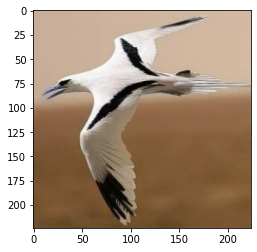

2022-05-07 21:07:44.072017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19
WHITE TAILED TROPIC


In [8]:
from tensorflow.keras.models import load_model

model = load_model('./models/vit_l32_finetuned.h5')

predict_image_path = './dataset/20test/WHITE TAILED TROPIC/1.jpg'

plt.imshow(cv2.imread(predict_image_path))
plt.show();
img = load_img(predict_image_path, target_size=(224,224))
img = img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = vit.preprocess_inputs(img)

predictions = model.predict(img)
label = decode(predictions)

print(label)